In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D,  SpatialDropout1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn import metrics
from sklearn.model_selection import KFold
from functools import reduce

import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

test = test.drop(test.columns[0], axis=1)
# using all data for visualization
all_data = pd.concat([train, test])

# using fast text embeding
embedding_file = 'data/crawl-300d-2M.vec'

In [25]:
all_data.peek()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


Total comments  223533
Total clean comments  201136
Total tags  toxic           21381
severe_toxic     1961
obscene         12137
threat            689
insult          11301
dtype: int64


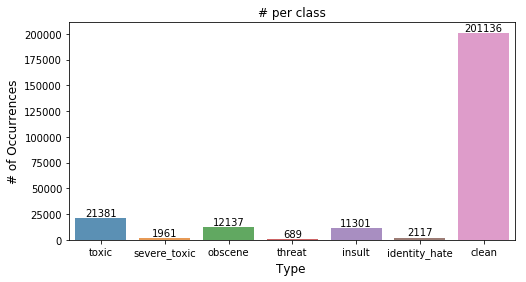

In [3]:
# Data visualizations
# Total clean comments

# marking comments without any tags as "clean".
rowsums = all_data.iloc[:,2:7].sum(axis=1)
all_data['clean'] = np.logical_not(rowsums).astype('int')

x = all_data.iloc[:,2:].sum()

# count number of clean entries
print("Total comments ", len(all_data))
print("Total clean comments ", all_data['clean'].sum())
print("Total tags ", all_data.iloc[:,2:7].sum())

# plot a graph of all the tags
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


The above visualization clearly shows that there is a class imbalance. Even among the toxic types. 

In [4]:
# Word count in each comment:
all_data['count_word'] = all_data["comment_text"].apply(lambda x: len(str(x).split()))

# Unique word count
all_data['count_unique_word'] = all_data["comment_text"].apply(lambda x: len(set(str(x).split())))

# percentage of unique words
all_data['word_unique_percent'] = all_data['count_unique_word']*100/all_data['count_word']

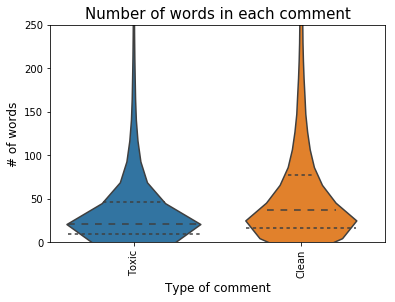

In [58]:
# word count
axes = sns.violinplot(y='count_word', x='clean', data=all_data,split=True, inner="quart")
axes.set_xlabel('Type of comment', fontsize=12)
axes.set_ylabel('# of words', fontsize=12)
axes.set_ylim([0, 250])
axes.set_xticklabels(['Toxic', 'Clean'], rotation='vertical', fontsize=10)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

The above plot indicates that the number of words in each comment in both clean and toxic comments is mostly between 10 to 50. And toxic comments are much more likely to have fewer words indicated by the bulk near ~20 range.

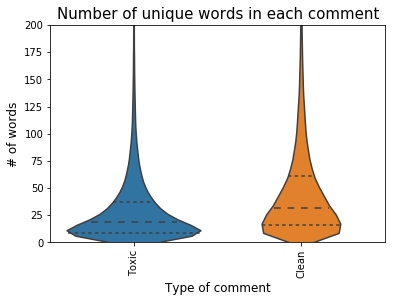

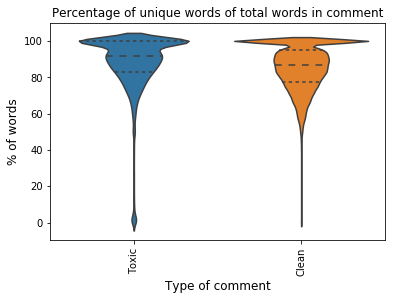

In [59]:
# unique word count
plt.title("Number of unique words in each comment", fontsize=15)
axes = sns.violinplot(y='count_unique_word', x='clean', data=all_data,split=True, inner="quart")
axes.set_xlabel('Type of comment', fontsize=12)
axes.set_ylabel('# of words', fontsize=12)
axes.set_ylim([0, 200])
axes.set_xticklabels(['Toxic', 'Clean'], rotation='vertical', fontsize=10)
plt.show()

# percentage of unique words
plt.title("Percentage of unique words of total words in comment")
axes = sns.violinplot(y='word_unique_percent', x='clean', data=all_data,split=True, inner="quart")
axes.set_xlabel('Type of comment', fontsize=12)
axes.set_ylabel('% of words', fontsize=12)
axes.set_xticklabels(['Toxic', 'Clean'], rotation='vertical', fontsize=10)
plt.show()


The above graphs show that number of words and number of unique words in both  clean and toxic comments are similar and the percentage of unique words indicate that the bulk of the words are unique only. Also, there is a very small bump in the percentage of unique words in toxic comments indicating that they are spam.

In [27]:
# check for nulls (There aren't any in this data)
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool)

In [3]:
# split data by class
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
y_test = test[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]


In [7]:
# clean data
special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def text_to_words(text):
    # remove special characters
    text=special_character_removal.sub('',text)
    
    # Replace Numbers with character 'n' 
    text=replace_numbers.sub('n', text)

    # Convert words to lower case and split them
    text = text.lower().split()
    
    # remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)

    # shorten words to their stems
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
        
    return stemmed_words

comments = []
for text in list_sentences_train:
    comments.append(text_to_words(text))
    
test_comments=[]
for text in list_sentences_test:
    test_comments.append(text_to_words(text))

In [7]:
# visualize word distribution
totalNumWords = [len(c) for c in list_tokenized_train]

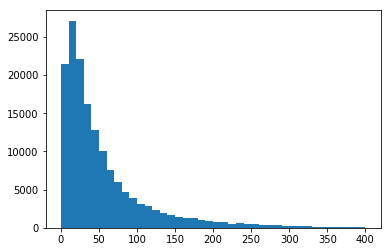

In [8]:
plt.hist(totalNumWords, bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

This graph shows the word distribution for the comments. Most of the comments have 0 to 50 words but there are some that has more than 300 words. It's very important to tokenize them to vectors of equal length before feeding them to the network

In [8]:
# tokenize strings to vectors by replacing words with numbers
# Set max no of words to keep as 20000.
max_features = 20000
maxlen = 100
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(comments + test_comments))

# pad the data to vectors of equal length by padding short sentences and trimming long sentences
def pad_data(input):
    comments_sequence = tokenizer.texts_to_sequences(input)
    return pad_sequences(comments_sequence, maxlen=maxlen)

X_t = pad_data(comments)
X_te = pad_data(test_comments)


In [9]:
# embedding
# fast text
embed_size =300

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file, encoding="utf8"))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector


In [10]:
# Define keras input layer
input = Input(shape=(maxlen, )) # maxlen = 100 as defined earlier

def get_model(lstm_size, cnn_size, cnn_stride, dropout):
    # define embedding layer
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(input)
    x = SpatialDropout1D(dropout)(x)
    # define bidirectional lstm layer
    x = Bidirectional(LSTM(lstm_size, return_sequences=True,name='lstm_layer'))(x)
    # output of lstm is feeded to a cnn network
    x = Conv1D(cnn_size, kernel_size = cnn_stride, padding = "valid", kernel_initializer = "he_uniform")(x)

    # pooling & dropout
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    x = Dropout(dropout)(x)

    # sigmoid for classification
    x = Dense(6, activation="sigmoid")(x)

    # create model
    model = Model(inputs=input, outputs=x)
    
    # compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()
    
    return model

In [14]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

In [8]:
get_model()

In [38]:
from keras.models import load_model
model = load_model('model.h5')

In [ ]:
# train model
batch_size = 32
epochs = 2
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)
model.save('model.h5')

In [29]:
batch_size = 1780
epochs = 2
kfold = KFold(n_splits= 10, shuffle=True)
lstm = [30, 60, 90, 120]
cnn = [30, 30, 60, 60]
cnn_stride = [2, 3, 2, 3]
dropout = [0.1, 0.2, 0.2, 0.3]
history_dfs = []
for i in range(4):
    histories = []
    model = get_model(lstm[i], cnn[i], cnn_stride[i], dropout[i])
    for train, test in kfold.split(X_t):
        history = model.fit(X_t[train], y[train], batch_size=batch_size, epochs=epochs, validation_split=0.2)
        histories.append(history)
    history_data = [h.history for h in histories]
    for h in history_data:
        for key, value in h.items():
            h[key] = reduce(lambda x, y: (x + y) / 2, value)
    history_df = pd.DataFrame(history_data)
    history_dfs.append(history_df)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 100, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_7 (SpatialDro (None, 100, 300)     0           embedding_7[0][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 100, 60)      79440       spatial_dropout1d_7[0][0]        
__________________________________________________________________________________________________
conv1d_7 (

Train on 114890 samples, validate on 28723 samples
Epoch 1/2
114890/114890 [==============================] - 25s 214us/step - loss: 0.2102 - acc: 0.9481 - val_loss: 0.0948 - val_acc: 0.9638
Epoch 2/2
114890/114890 [==============================] - 22s 190us/step - loss: 0.0720 - acc: 0.9756 - val_loss: 0.0572 - val_acc: 0.9799
Train on 114891 samples, validate on 28723 samples
Epoch 1/2
114891/114891 [==============================] - 23s 196us/step - loss: 0.0577 - acc: 0.9799 - val_loss: 0.0556 - val_acc: 0.9806
Epoch 2/2
114891/114891 [==============================] - 22s 192us/step - loss: 0.0530 - acc: 0.9811 - val_loss: 0.0523 - val_acc: 0.9814
Train on 114891 samples, validate on 28723 samples
Epoch 1/2
114891/114891 [==============================] - 22s 191us/step - loss: 0.0498 - acc: 0.9822 - val_loss: 0.0512 - val_acc: 0.9817
Epoch 2/2
114891/114891 [==============================] - 22s 192us/step - loss: 0.0472 - acc: 0.9828 - val_loss: 0.0512 - val_acc: 0.9817
Train o

114891/114891 [==============================] - 25s 221us/step - loss: 0.0293 - acc: 0.9885 - val_loss: 0.0578 - val_acc: 0.9810
Epoch 2/2
114891/114891 [==============================] - 26s 223us/step - loss: 0.0277 - acc: 0.9892 - val_loss: 0.0593 - val_acc: 0.9810
Train on 114891 samples, validate on 28723 samples
Epoch 1/2
114891/114891 [==============================] - 26s 222us/step - loss: 0.0265 - acc: 0.9898 - val_loss: 0.0627 - val_acc: 0.9808
Epoch 2/2
114891/114891 [==============================] - 25s 221us/step - loss: 0.0246 - acc: 0.9907 - val_loss: 0.0643 - val_acc: 0.9801
Train on 114891 samples, validate on 28723 samples
Epoch 1/2
114891/114891 [==============================] - 26s 224us/step - loss: 0.0238 - acc: 0.9910 - val_loss: 0.0670 - val_acc: 0.9804
Epoch 2/2
114891/114891 [==============================] - 26s 223us/step - loss: 0.0220 - acc: 0.9916 - val_loss: 0.0697 - val_acc: 0.9800
____________________________________________________________________

In [30]:
history_dfs

[        acc      loss   val_acc  val_loss
 0  0.952650  0.161660  0.970915  0.090429
 1  0.980127  0.057246  0.980222  0.056042
 2  0.982343  0.048484  0.981600  0.051994
 3  0.983707  0.044276  0.981475  0.051796
 4  0.984859  0.040432  0.981594  0.052227
 5  0.985954  0.037372  0.981655  0.052745
 6  0.986796  0.034976  0.981246  0.055151
 7  0.988166  0.031345  0.981107  0.057097
 8  0.989487  0.028155  0.980965  0.059487
 9  0.990301  0.026004  0.980892  0.061381,
         acc      loss   val_acc  val_loss
 0  0.961863  0.141098  0.971811  0.076011
 1  0.980534  0.055379  0.981002  0.053925
 2  0.982493  0.048506  0.981705  0.051167
 3  0.983527  0.044350  0.981516  0.052144
 4  0.984397  0.041145  0.981882  0.051505
 5  0.985607  0.037528  0.981855  0.053891
 6  0.986669  0.034908  0.981702  0.055061
 7  0.987685  0.031983  0.981092  0.056107
 8  0.988670  0.029407  0.981136  0.058791
 9  0.989756  0.026866  0.980599  0.062031,
         acc      loss   val_acc  val_loss
 0  0.966

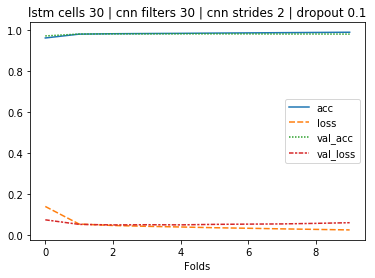

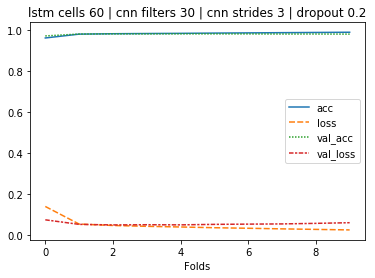

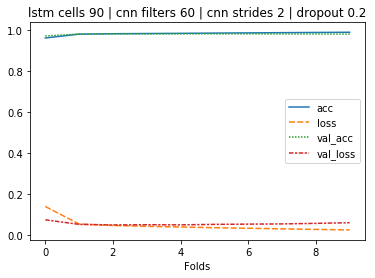

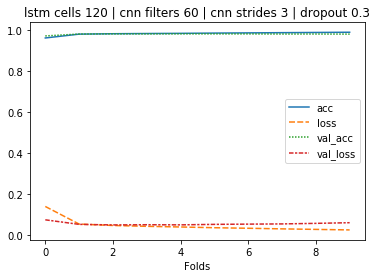

In [36]:
for i in range(len(history_dfs)):
    fig = plt.figure(i)
    title = "lstm cells " + str(lstm[i]) + " | cnn filters " + str(cnn[i]) + " | cnn strides " + str(cnn_stride[i]) + " | dropout " + str(dropout[i]) + ""
    plt.title(title)
    plt.xlabel('Folds')
    sns.lineplot(data=history_dfs[1])

In [33]:
for i in range(len(history_dfs)):
    title = "lstm cells " + str(lstm[i]) + " | cnn filters " + str(cnn[i]) + " | cnn strides " + str(cnn_stride[i]) + " | dropout " + str(dropout[i]) + ""
    print(title)
    mean_validation_loss = np.mean(history_dfs[i].val_loss.values)
    variance_validation_loss = np.var(history_dfs[i].val_loss.values)

    mean_validation_accuracy = np.mean(history_dfs[i].val_acc.values)
    variance_validation_accuracy = np.var(history_dfs[i].val_acc.values)

    print("Mean of validation loss :", mean_validation_loss)
    print("Variance of validation loss :", variance_validation_loss)
    print("Mean of validation accuracy :", mean_validation_accuracy)
    print("Variance of validation accuracy :", variance_validation_accuracy)

lstm cells 30 | cnn filters 30 | cnn strides 2 | dropout 0.1
Mean of validation loss : 0.058834951277546656
Variance of validation loss : 0.00012065656784282981
Mean of validation accuracy : 0.9801671659953083
Variance of validation accuracy : 9.68356868005733e-06
lstm cells 60 | cnn filters 30 | cnn strides 3 | dropout 0.2
Mean of validation loss : 0.05706344353535009
Variance of validation loss : 5.0135825168220734e-05
Mean of validation accuracy : 0.9804300261667311
Variance of validation accuracy : 8.413672602476248e-06
lstm cells 90 | cnn filters 60 | cnn strides 2 | dropout 0.2
Mean of validation loss : 0.05613930753644884
Variance of validation loss : 4.228854554445845e-05
Mean of validation accuracy : 0.9811872583656547
Variance of validation accuracy : 1.4784551311087157e-06
lstm cells 120 | cnn filters 60 | cnn strides 3 | dropout 0.3
Mean of validation loss : 0.05417640228897693
Variance of validation loss : 2.7418915412924683e-05
Mean of validation accuracy : 0.981506395905

In [56]:
mean_validation_loss = np.mean(history_df.val_loss.values)
variance_validation_loss = np.var(history_df.val_loss.values)

mean_validation_accuracy = np.mean(history_df.val_acc.values)
variance_validation_accuracy = np.var(history_df.val_acc.values)

print("Mean of validation loss :", mean_validation_loss)
print("Variance of validation loss :", variance_validation_loss)
print("Mean of validation accuracy :", mean_validation_accuracy)
print("Variance of validation accuracy :", variance_validation_accuracy)

Mean of validation loss : 0.09451208911201131
Variance of validation loss : 0.0009518949179916986
Mean of validation accuracy : 0.9798671672270165
Variance of validation accuracy : 1.640562328473234e-06


In [34]:
# test model
batch_size = 1760
epochs = 2
predictions = model.predict(X_te, batch_size=batch_size, verbose=1)

63962/63962 [==============================] - 6s 94us/step


In [35]:
for l in range(len(list_classes)):
    print("\n" + list_classes[l])
    print("roc auc score ", metrics.roc_auc_score(y_test[:,l], predictions[:,l]))
    print("accuracy ", metrics.accuracy_score(y_test[:,l], np.round(predictions[:,l]).astype(np.int)))
    print("precision score ", metrics.precision_score(y_test[:,l], np.round(predictions[:,l]).astype(np.int),  average='weighted'))
    print("recall score ", metrics.recall_score(y_test[:,l], np.round(predictions[:,l]).astype(np.int),  average='weighted'))
    print("f1 score ", metrics.f1_score(y_test[:,l], np.round(predictions[:,l]).astype(np.int), average='weighted'))

print("\n" + "Overall")
print("roc auc score ", metrics.roc_auc_score(y_test, predictions))
print("accuracy ", metrics.accuracy_score(y_test, np.round(predictions).astype(np.int)))
print("precision score ", metrics.precision_score(y_test, np.round(predictions).astype(np.int),  average='weighted'))
print("recall score ", metrics.recall_score(y_test, np.round(predictions).astype(np.int),  average='weighted'))
print("f1 score ", metrics.f1_score(y_test, np.round(predictions).astype(np.int), average='weighted'))



toxic
roc auc score  0.953988236091433
accuracy  0.9067415027672681
precision score  0.9363067098478128
recall score  0.9067415027672681
f1 score  0.9165643074041075

severe_toxic
roc auc score  0.9836327859572569
accuracy  0.9937462868578218
precision score  0.9927235192586961
recall score  0.9937462868578218
f1 score  0.9931603123346169

obscene
roc auc score  0.969388945399523
accuracy  0.9562552765704637
precision score  0.9611353933979744
recall score  0.9562552765704637
f1 score  0.9582760187980782

threat
roc auc score  0.9813860368029912
accuracy  0.9959819893061506
precision score  0.9960480411076571
recall score  0.9959819893061506
f1 score  0.996014659976519

insult
roc auc score  0.9606876086827986
accuracy  0.9556611738219568
precision score  0.9577936025519689
recall score  0.9556611738219568
f1 score  0.956647380070736

identity_hate
roc auc score  0.9743078895945286
accuracy  0.9896344704668397
precision score  0.9890017249566241
recall score  0.9896344704668397
f1 sco

In [15]:
pd.DataFrame(predictions).to_csv('data/predictions.csv')

<generator object _BaseKFold.split at 0x7fb3f2c1d360>

In [15]:
def predict(input):
    input = text_to_words(input)
    input_padded = pad_data([input])
    return model.predict(input_padded, verbose=1)


In [16]:
# Test with twitter data
# https://aaai.org/ocs/index.php/ICWSM/ICWSM17/paper/view/15665/14843
test_twitter = pd.read_csv('data/test_twitter.csv')
test_twitter.head()
list_twitter = test_twitter.tweet


In [17]:
tweets = []
for text in list_twitter:
    tweets.append(text_to_words(text))
tweets_padded = pad_data(tweets)
tweet_predictions = model.predict(tweets_padded, verbose=1)

24783/24783 [==============================] - 24s 974us/step


In [18]:
# find the number of tweets tagged any type of toxic
toxic_tweets = list(filter(lambda x: any([j >= 0.5 for j in x]), tweet_predictions))

total_tweets = len(list_twitter)

toxic_percent = len(toxic_tweets) / total_tweets

In [19]:
tweet_predictions_consolidated = [max(i) for i in tweet_predictions ]


In [20]:
test_classes = []
for i, r in test_twitter.iterrows():
    if r.hate_speech > r.neither or r.offensive_language > r.neither:
        test_classes.append(1)
    else:
        test_classes.append(0)

In [21]:
print("roc auc score ", metrics.roc_auc_score(test_classes, tweet_predictions_consolidated))
print("accuracy ", metrics.accuracy_score(test_classes, np.round(tweet_predictions_consolidated).astype(np.int)))
print("precision score ", metrics.precision_score(test_classes, np.round(tweet_predictions_consolidated).astype(np.int),  average='weighted'))
print("recall score ", metrics.recall_score(test_classes, np.round(tweet_predictions_consolidated).astype(np.int),  average='weighted'))
print("f1 score ", metrics.f1_score(test_classes, np.round(tweet_predictions_consolidated).astype(np.int), average='weighted'))

roc auc score  0.9230182036428721
accuracy  0.8367832788605092
precision score  0.8843062962705952
recall score  0.8367832788605092
f1 score  0.8507428168598588


F1 score in the paper presented is 0.9